In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models

Welcome to JupyROOT 6.20/06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


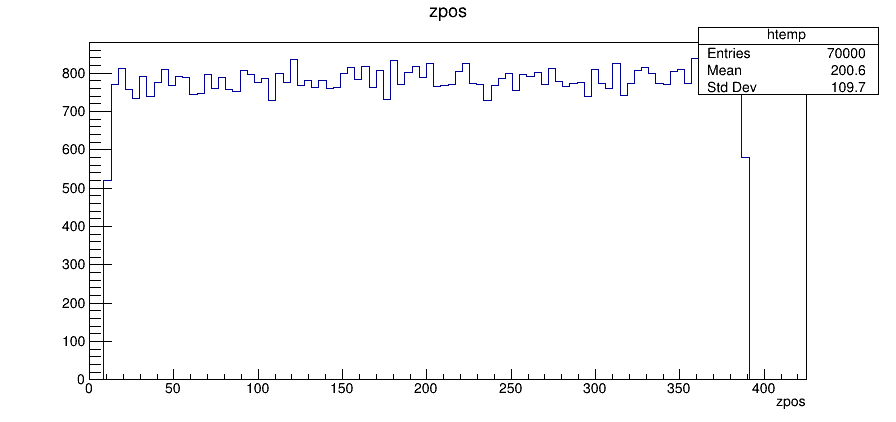

In [3]:
canv = ROOT.TCanvas("canv","canv",900,450)
ds = ROOT.TChain("tree")
ds.Add("new_00.root")
ds.Add("new_01.root")
ds.Add("new_02.root")
ds.Add("new_03.root")
ds.Add("new_04.root")
ds.Add("new_05.root")
ds.Add("new_06.root")
ds.Add("new_07.root")
ds.Add("new_08.root")
ds.Add("new_09.root")
ds.Draw("zpos")
canv.Draw()

In [152]:
from math import atan, sqrt
W1   = 0.004 # mm/ns
zCSC = 853.1 # mm
T23 = 4.97526
my_events = []
for ev in ds:
    lCSC  = sqrt( ev.xCSC**2 + ev.yCSC**2 )
    zTPC  = ev.peak1*W1
    Treco = ev.T/35310.
    if Treco >T23-0.05 and Treco<T23+0.05:
        evt = {"t":Treco, "l":lCSC, "z":zTPC, "Atr":ev.THETAe, "Ttr":ev.Tp, "Ztr":ev.zpos}
        my_events.append( evt )
print("EVENTS SELECTED: " + str(len(my_events)))

EVENTS SELECTED: 29933


Mean dZ = ( -2.19026 +- 0.00154718 )
RMS  dZ = ( 0.266385 +- 0.00524278 )


Warning in <TROOT::Append>: Replacing existing TH1: hDZtrue (Potential memory leak).


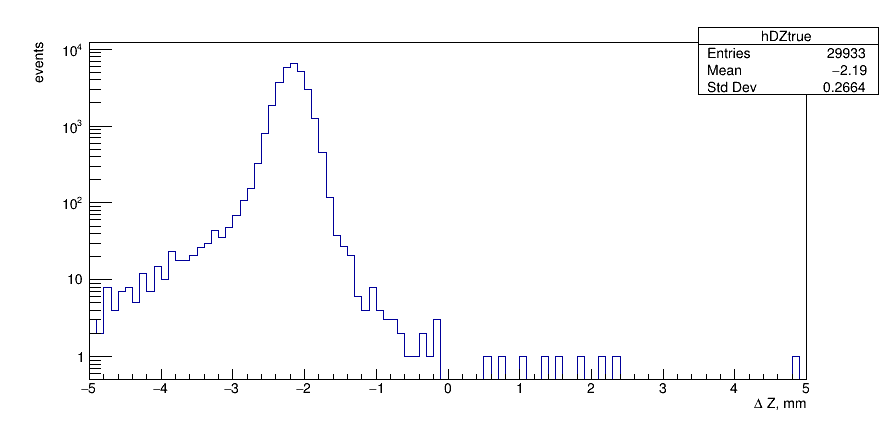

In [153]:
hDZtrue = ROOT.TH1F("hDZtrue",";#Delta Z, mm;events",100,-5,5)
for ev in my_events:
    hDZtrue.Fill(ev["Ztr"] - ev["z"])
hDZtrue.Draw()
print("Mean dZ = " + str(hDZtrue.mean()))
print("RMS  dZ = " + str(hDZtrue.rms()))
ROOT.gPad.SetLogy()
canv.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_ang (Potential memory leak).


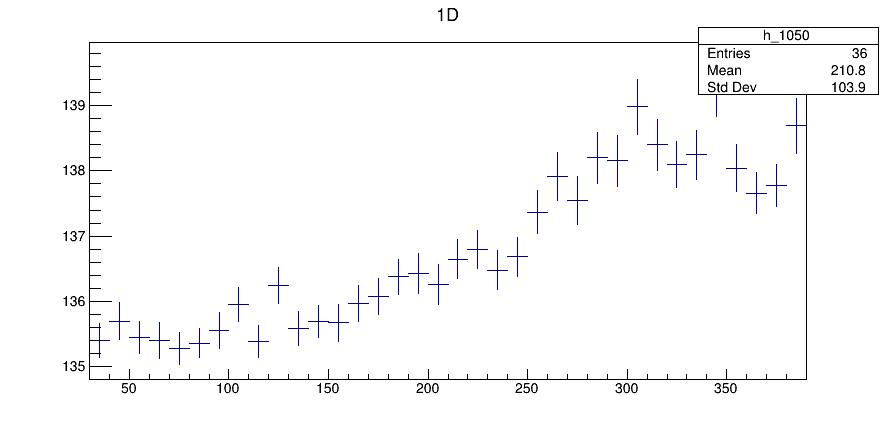

In [154]:
ROOT.gPad.SetLogy(False)
zCSC = 853.1
z_bins = []
for i in range(37):
    z_bins.append(30.+10.*i)
hARz = h1_axis(z_bins)
h_ang = ROOT.TH1F("h_ang",";#theta_{REC}, mrad;events",1000,100,200)
for idx in range(len(z_bins)-1):
    h_ang.Reset()
    for ev in my_events:
        if ev["z"]>z_bins[idx] and ev["z"]<z_bins[idx+1]:
            h_ang.Fill(1000.*atan( ev["l"]/(zCSC - ev["z"]) ) )
    hARz[idx+1] = VE( h_ang.mean().value(), h_ang.mean().error()**2 )
hARz.Draw()
canv.Draw()

In [155]:
h_mis = ROOT.TH1F("h_mis",";#theta_{REC}-#theta_{TRUE}, mrad;events",160,-8,8)
z_shifts  = []
chi2_list = []
hTEMP = h1_axis(z_bins)
for jdx in range(40):
    hTEMP.Reset()
    dz = -2.1-jdx*0.02
    for idx in range(len(z_bins)-1):
        h_ang.Reset()
        h_mis.Reset()
        for ev in my_events:
            if ev["z"]+dz>z_bins[idx] and ev["z"]+dz<z_bins[idx+1]:
                a_rec = 1000.*atan( ev["l"]/(zCSC - (ev["z"]+dz) ) )
                h_ang.Fill( a_rec )
                h_mis.Fill(a_rec - 1000.*ev["Atr"] )
#        hTEMP[idx+1] = VE( h_ang.mean().value(), h_ang.mean().error()**2 )
        hTEMP[idx+1] = VE( h_mis.mean().value(), h_mis.mean().error()**2 )
    res = hTEMP.Fit( "pol0", "S" )
    z_shifts.append(dz)
    chi2_list.append( res.Chi2() )


****************************************
Minimizer is Linear / Migrad
Chi2                      =      31.9414
NDf                       =           35
p0                        =    0.0226783   +/-   0.00502345  

****************************************
Minimizer is Linear / Migrad
Chi2                      =      31.3903
NDf                       =           35
p0                        =    0.0182929   +/-   0.00502414  

****************************************
Minimizer is Linear / Migrad
Chi2                      =      31.6674
NDf                       =           35
p0                        =    0.0140902   +/-   0.00502242  

****************************************
Minimizer is Linear / Migrad
Chi2                      =      30.7702
NDf                       =           35
p0                        =   0.00976819   +/-   0.00502178  

****************************************
Minimizer is Linear / Migrad
Chi2                      =      30.1012
NDf                       = 

Warning in <TROOT::Append>: Replacing existing TH1: h_mis (Potential memory leak).


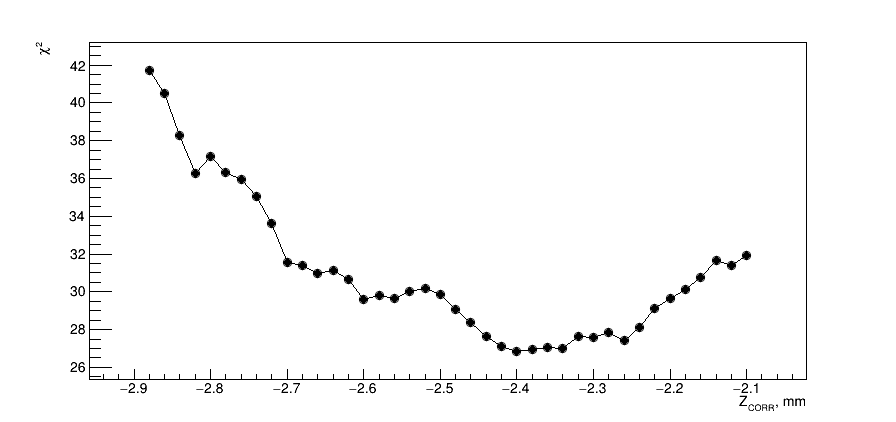

In [156]:
gr_chi2 = makeGraph(z_shifts,chi2_list)
gr_chi2.SetTitle("")
gr_chi2.GetXaxis().SetTitle("Z_{CORR}, mm")
gr_chi2.GetYaxis().SetTitle("#chi^{2}")
gr_chi2.SetMarkerStyle(20)
gr_chi2.Draw("APL")
canv.Draw()

In [157]:
dZ_mc = -2.19
dZ_dt = -2.41

In [158]:
from statistics import mean, stdev, median
z_bins[-1]

390.0

180.0
30.0 - 210.0	134.4738014068268
		134.18596136777361
40.0 - 220.0	134.4709022583955
		134.82358936143453
50.0 - 230.0	134.22236242412822
		134.2372105301128
60.0 - 240.0	134.04727526237883
		133.89561390978423
70.0 - 250.0	134.25673958943204
		133.91471411172415
80.0 - 260.0	134.3730894242567
		134.17196481933757
90.0 - 270.0	134.2399555176541
		134.2414902651259
100.0 - 280.0	133.8425773942505
		133.44480833008237
110.0 - 290.0	134.41219351982545
		134.4586918050151
120.0 - 300.0	134.05344147592223
		134.27529607673085
130.0 - 310.0	134.1505823431618
		134.25190720085746
140.0 - 320.0	134.57464419356964
		134.43222984815816
150.0 - 330.0	134.010022607891
		133.7611050208769
160.0 - 340.0	134.20322542759862
		133.76816555011325
170.0 - 350.0	134.30303991041774
		134.12672352274066
180.0 - 360.0	134.8180965873263
		134.81070723343234
190.0 - 370.0	134.32038468920518
		134.3989554652359
200.0 - 380.0	134.41449401615793
		134.59105372331004


Warning in <TROOT::Append>: Replacing existing TH1: hMedianMean (Potential memory leak).


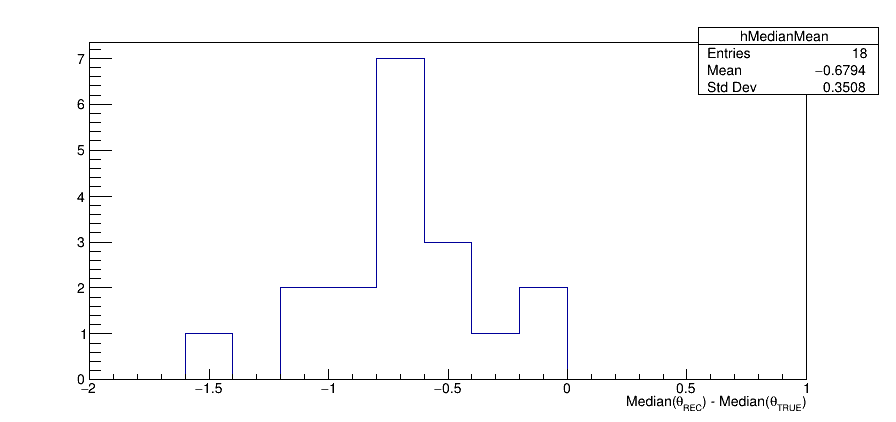

In [159]:
Nsteps = int( (len(z_bins)-1)/2 )
DeltaZ = z_bins[Nsteps]-z_bins[0]
print(DeltaZ)
hMedianMiss = ROOT.TH1F("hMedianMean",";Median(#theta_{REC}) - Median(#theta_{TRUE})",15,-2,1)
for idx in range(Nsteps):
    Lclose_list = []
    Lfar_list = []
    Zclose_list = []
    Zfar_list = []
    for ev in my_events:
#        cZ = ev["z"]+dZ_mc
        cZ = ev["Ztr"]
        if cZ>z_bins[idx] and cZ<z_bins[idx+1]:
            Lfar_list.append(ev["l"])
            Zfar_list.append(cZ)
        if cZ>z_bins[idx+Nsteps] and cZ<z_bins[idx+1+Nsteps]:
            Lclose_list.append(ev["l"])
            Zclose_list.append(cZ)
    DeltaL = median(Lfar_list) - median(Lclose_list)    
    DeltaZm=-median(Zfar_list) + median(Zclose_list)    
    print(str(z_bins[idx]) + " - " + str(z_bins[idx+Nsteps]) + "\t" + str(1000.*atan(DeltaL/DeltaZ)))
    print("\t\t" + str(1000.*atan(DeltaL/DeltaZm)))
    hMedianMiss.Fill( 1000.*atan(DeltaL/DeltaZm) - 134.89 )
#    print("\t"+str(len(Lfar_list)) +"\t"+str(len(Lclose_list)))
hMedianMiss.Draw()
canv.Draw()

In [160]:
Lclose_list = []
Lfar_list   = []
Zclose_list = []
Zfar_list   = []
for ev in my_events:
    if ev["z"]+dZ_mc>45 and ev["z"]+dZ_mc<65:
        Lfar_list.append(ev["l"])
        Zfar_list.append(ev["z"]+dZ_mc)
    if ev["z"]+dZ_mc>355 and ev["z"]+dZ_mc<375:
        Lclose_list.append(ev["l"])
        Zclose_list.append(ev["z"]+dZ_mc)
print("Median (far)  : " + str(median(Lfar_list)))
print("              : " + str(median(Zfar_list)))
print("Median (close): " + str(median(Lclose_list)))
print("              : " + str(median(Zclose_list)))
dL =  median(Lfar_list) - median(Lclose_list)
dZ = -median(Zfar_list) + median(Zclose_list)
print("Median angle  : " + str(1000.*atan(dL/310.)))
print("              : " + str(1000.*atan(dL/dZ  )))
print("              : " + str(dL) + " / " +str(dZ) )

Median (far)  : 108.29132098901212
              : 54.78723046875
Median (close): 66.40690870747865
              : 364.94026562500005
Median angle  : 134.29774680934287
              : 134.23227517167234
              : 41.88441228153347 / 310.15303515625004


In [149]:
Atr_list = []
for ev in my_events:
    Atr_list.append(1000.*ev["Atr"])
print("Median aTRUE: " + str(median(Atr_list)))

Median aTRUE: 134.89000499248505


In [150]:
len(Lclose_list)

795

In [151]:
0.6/134.88

0.004448398576512455